In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
import json
import time

In [2]:
def sift_transform(ref_img,train_img,blur_val=7,dist_val=0.9,MIN_MATCH_COUNT = 40,show_match=True):
    ratio_blur = train_img.shape[0]/ref_img.shape[0]
    blur_t = blur_val * ratio_blur
    blur_t_odd = int(blur_val/2)*2 + 1
    ref_img = cv2.GaussianBlur(ref_img,(blur_val,blur_val),0)
    train_img = cv2.GaussianBlur(train_img,(blur_t_odd,blur_t_odd),0)
    if ref_img.shape[2] == 3:
        ref_img_gray = cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY)
        train_img_gray = cv2.cvtColor(train_img,cv2.COLOR_BGR2GRAY)
    else:
        ref_img_gray = ref_img
        train_img_gray = train_img
    height,width = ref_img_gray.shape
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(ref_img_gray,None)
    kp2, des2 = sift.detectAndCompute(train_img_gray,None)
    print(kp1[0],des1)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 500)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    #print((matches))
    for m,n in matches:
        if m.distance < dist_val*n.distance:
            good.append(m)
    print(len(good))
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M1, mask1 = cv2.findHomography(dst_pts , src_pts, cv2.RANSAC,5.0)
        transformed_img = cv2.warpPerspective(train_img,M1, (width, height))
        transformed_img_gray = cv2.warpPerspective(train_img_gray,M1, (width, height))
        if show_match == True:
            M, mask = cv2.findHomography(src_pts,dst_pts , cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            pts = np.float32([ [0,0],[0,height-1],[width-1,height-1],[width-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            ref_img_gray_p = cv2.polylines(ref_img_gray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    if show_match:
        draw_params = dict(matchColor = (0,255,0), singlePointColor = None,matchesMask = matchesMask, flags = 2)
        match_img = cv2.drawMatches(ref_img_gray_p,kp1,train_img_gray,kp2,good,None,**draw_params)
    else:
        match_img = None
    return transformed_img,transformed_img_gray,ref_img_gray,match_img,M1,(width, height)

In [3]:
def kmean(ref_img,K=1):
    #print(K)
    Z = ref_img.reshape((-1,1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((ref_img.shape))
    return res2,center

def get_center_img_kmean(train_img,cts):
    print(cts)
    m,n,o = cts[0].shape[0],cts[1].shape[0],cts[2].shape[0]
    train_b = train_img[:,:,0]
    train_g = train_img[:,:,1]
    train_r = train_img[:,:,2]
    bs = (train_img.shape[0],train_img.shape[1])
    final_img = np.zeros(train_img.shape,dtype=np.uint8)
    p = [0]
    q = [0]
    r = [0]
    for i in range(0,m-1):
        p.append(int((int(cts[0][i,0])+int(cts[0][i+1,0]))/2))
    for i in range(0,n-1):
        q.append(int((int(cts[1][i,0])+int(cts[1][i+1,0]))/2))
    for i in range(0,o-1):
        r.append(int(int((cts[2][i,0])+int(cts[2][i+1,0]))/2))
    p.append(256)
    q.append(256)
    r.append(256)
    p.sort()
    q.sort()
    r.sort()
    cc=0
    print(p,q,r)
    #print(m,n,o,len(p),len(q),len(r))
    for i in range(m):
        temp_mask = get_temp_mask(train[:,:,0],p[i],p[i+1])
        print(p[i],p[i+1])
        #plt.imshow(temp_mask)
        final_img[:,:,0] += np.uint8(temp_mask*cts[0][i,0])
        #cv2.imwrite(str(cc)+'.png',temp_mask*255)
        cc+=1
    for i in range(n):
        temp_mask = get_temp_mask(train[:,:,1],q[i],q[i+1])
        print(q[i],q[i+1])
        #plt.imshow(temp_mask)
        final_img[:,:,1] += np.uint8(temp_mask*cts[1][i,0])
        #cv2.imwrite(str(cc)+'.png',temp_mask*255)
        cc+=1
    for i in range(o):
        temp_mask = get_temp_mask(train[:,:,2],r[i],r[i+1])
        print(r[i],r[i+1])
        #plt.imshow(temp_mask)
        final_img[:,:,2] += np.uint8(temp_mask*cts[2][i,0])
        #cv2.imwrite(str(cc)+'.png',temp_mask*255)
        cc+=1
    return final_img

    '''
    for i in range(m):    
        temp_mask = np.zeros(bs,dtype=np.uint8)
        temp_mask = (train_img[:,:,0]>=p[i]) | (train_img[:,:,0]<p[i+1])
        print(p[i],p[i+1])
        plt.imshow(temp_mask)
        final_img[:,:,0] += temp_mask*cts[0][i,0]
    i=0
    for i in range(n):    
        temp_mask = np.zeros(bs,dtype=np.uint8)
        temp_mask = (train_img[:,:,1]>=q[i]) | (train_img[:,:,1]<q[i+1])
        final_img[:,:,1] += temp_mask*cts[1][i,0]
    for i in range(o):    
        temp_mask = np.zeros(bs,dtype=np.uint8)
        temp_mask = (train_img[:,:,2]>=q[i]) | (train_img[:,:,2]<q[i+1])
        final_img[:,:,2] += temp_mask*cts[2][i,0]
    return np.uint8(final_img)
'''
def get_temp_mask(train_layer,mink,maxk):
    mask = np.zeros(train_layer.shape,dtype=np.uint8)
    b1 = np.greater_equal(train_layer,mink)
    b2 = np.less(train_layer,maxk)
    mask = np.bitwise_and(b1,b2)*1
    return mask

In [4]:
def get_fail(sub_img,data_json,xor_bool=False,image_scale=0.5):
    if xor_bool == True:
        sub_img_g,otsu_sub_img = cv2.threshold(sub_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        print('Otsu Threshold : ',sub_img_g)
    else:
        otsu_sub_img = sub_img
    probs = []
    for i in data_json['shapes']:
        mask = np.zeros(otsu_sub_img.shape)
        ptrs = np.array(np.array(i['points'])*image_scale,dtype=np.int32)
        mask = cv2.fillPoly(mask, pts=[ptrs], color=(255))
        mask_sub = np.bitwise_and(otsu_sub_img.astype(np.uint8),mask.astype(np.uint8))
        prob = np.sum(mask_sub)/np.sum(mask)
        probs.append(prob)
        print(i['label'],' -> ',prob)
        #print(i)
    return probs

def create_mask(ref_img,data_json,color='gray',image_scale=0.5):
    if(color == 'gray'):
        mask = np.zeros(ref_img.shape[0:2])
    else:
        mask = np.zeros(ref_img.shape)
    for i in data_json['shapes']:
        ptrs = np.array(np.array(i['points'])*image_scale,dtype=np.int32)
        mask = cv2.fillPoly(mask, pts=[ptrs], color=(255, 255, 255))
        #print(i)
    return mask

def create_polyline_prob(ref_img,data_json,probs = [],probs_disp = False,prob_cmp=0,color='gray',image_scale=0.5,thickness=2,color_val=(0,255,0),color_text=(0,0,255)):
    try:
        ref_img.shape[2]
    except:
        ref_img = cv2.cvtColor(ref_img,cv2.COLOR_GRAY2BGR)
    c = -1
    for i in data_json['shapes']:
        c+=1
        ptrs = np.array(np.array(i['points'])*image_scale,dtype=np.int32)
        ref_img = cv2.polylines(ref_img, [ptrs],True, color_val, thickness)
        if(probs_disp and probs[c]>prob_cmp):
            org = (int(ptrs[0][0]),int(ptrs[0][1])-5)
            ref_img = cv2.putText(ref_img, str(round(probs[c],2)), org, cv2.FONT_HERSHEY_SIMPLEX,1*image_scale, color_text, 2, cv2.LINE_AA)
        #print(i)
    return ref_img

In [5]:
#ref = cv2.imread('/home/sam/PCB/master/images/setup/images/arduino/ref/arduino_ref_cp.png')
#train = cv2.imread('/home/sam/PCB/master/images/setup/images/arduino/train/5.jpg')
#data = json.load(open('/home/sam/PCB/master/images/setup/images/arduino/ref/arduino_ref_cp.json'))

ref = cv2.imread('/home/sam/PCB/master/images/mega2560/ref/ref_cp.png')
train = cv2.imread('/home/sam/PCB/master/images/mega2560/train/1.png')
data = json.load(open('/home/sam/PCB/master/images/mega2560/ref/ref_cp.json'))

n = 1
ref = cv2.resize(ref,(int(ref.shape[1]/n),int(ref.shape[0]/n)))
print(ref.shape)
#f, axarr = plt.subplots(3,1,figsize=(20, 20))

(561, 986, 3)


[[  6]
 [ 14]
 [ 22]
 [ 35]
 [ 50]
 [ 81]
 [114]
 [143]
 [163]
 [184]] [[  8]
 [ 16]
 [ 28]
 [ 43]
 [ 58]
 [ 78]
 [101]
 [123]
 [147]
 [169]] [[  6]
 [ 12]
 [ 16]
 [ 23]
 [ 32]
 [ 44]
 [ 72]
 [107]
 [143]
 [176]]


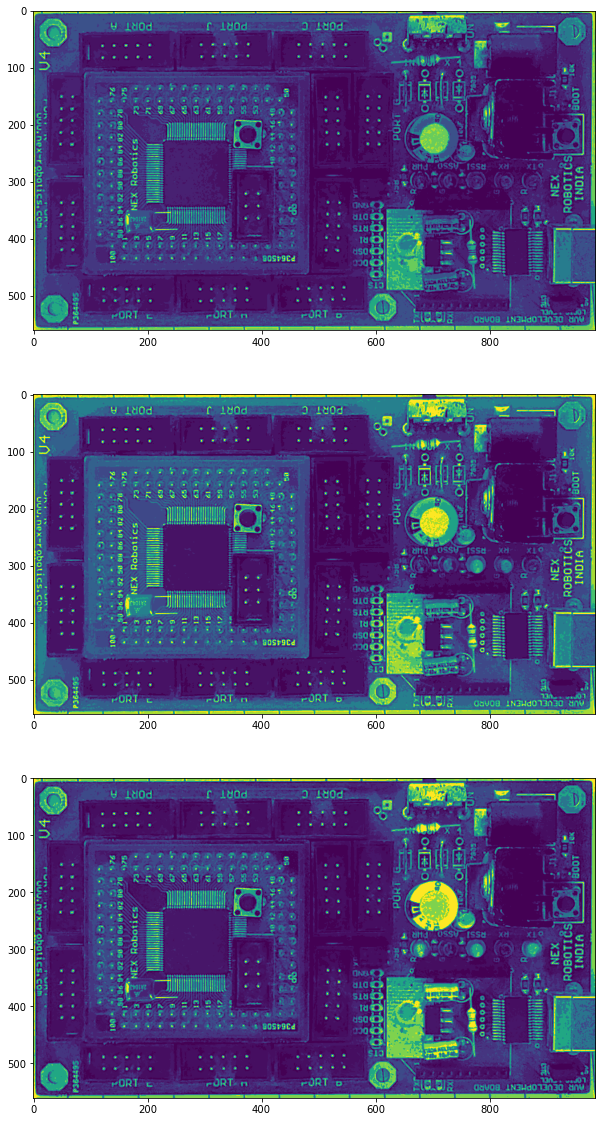

In [6]:
k = 10
refk = np.zeros(ref.shape,dtype=np.uint8)
refk[:,:,0],cts1 = kmean(ref[:,:,0],k)
refk[:,:,1],cts2 = kmean(ref[:,:,1],k)
refk[:,:,2],cts3 = kmean(ref[:,:,2],k)
#cv2.imwrite('kmean_ref.png',refk)
cts1 = np.sort(cts1,axis=0)
cts2 = np.sort(cts2,axis=0)
cts3 = np.sort(cts3,axis=0)
print(cts1,cts2,cts3)
f, axarr = plt.subplots(3,1,figsize=(20, 20))
axarr[0].imshow(refk[:,:,0])
axarr[1].imshow(refk[:,:,1])
axarr[2].imshow(refk[:,:,2])

[array([[  6],
       [ 14],
       [ 22],
       [ 35],
       [ 50],
       [ 81],
       [114],
       [143],
       [163],
       [184]], dtype=uint8), array([[  8],
       [ 16],
       [ 28],
       [ 43],
       [ 58],
       [ 78],
       [101],
       [123],
       [147],
       [169]], dtype=uint8), array([[  6],
       [ 12],
       [ 16],
       [ 23],
       [ 32],
       [ 44],
       [ 72],
       [107],
       [143],
       [176]], dtype=uint8)]
[0, 10, 18, 28, 42, 65, 97, 128, 153, 173, 256] [0, 12, 22, 35, 50, 68, 89, 112, 135, 158, 256] [0, 9, 14, 19, 27, 38, 58, 89, 125, 159, 256]
0 10
10 18
18 28
28 42
42 65
65 97
97 128
128 153
153 173
173 256
0 12
12 22
22 35
35 50
50 68
68 89
89 112
112 135
135 158
158 256
0 9
9 14
14 19
19 27
27 38
38 58
58 89
89 125
125 159
159 256


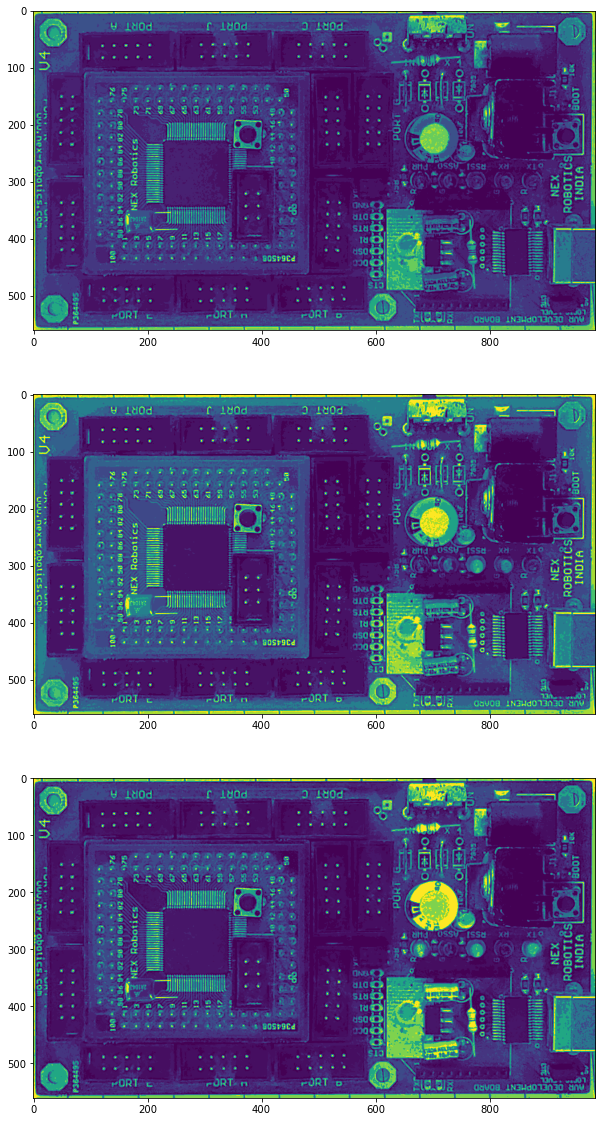

In [7]:
traink = get_center_img_kmean(train,[cts1,cts2,cts3])
f, axarr = plt.subplots(3,1,figsize=(20, 20))
axarr[0].imshow(refk[:,:,0])
axarr[1].imshow(refk[:,:,1])
axarr[2].imshow(refk[:,:,2])

< cv2.KeyPoint 0x7f7a541ec420> [[ 39.  28.  10. ...   0.   0.   0.]
 [ 26.  45.  38. ...   0.   0.   0.]
 [102.  39.   1. ...   0.   0.   0.]
 ...
 [ 38.   6.   0. ...  24.   3.  13.]
 [ 13.  13.   6. ...   0.   0.  21.]
 [ 52.  11.   0. ...  18.   1.   3.]]
719


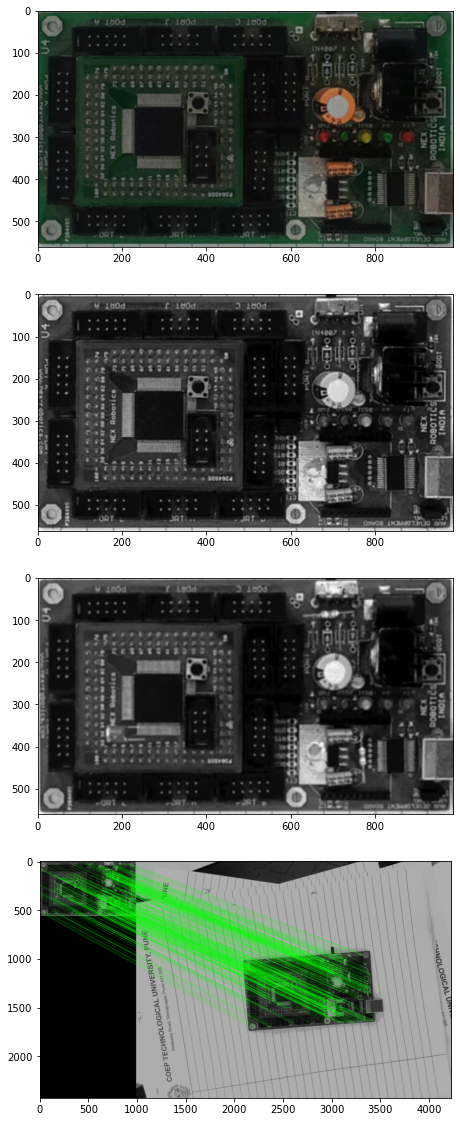

In [8]:
t_i,t_i_g,ref_g,m_i,M_warp,dim = sift_transform(refk,traink,blur_val = 11)
f, axarr = plt.subplots(4,1,figsize=(20, 20))
axarr[0].imshow(t_i[:,:,::-1])
axarr[1].imshow(t_i_g,'gray')
axarr[2].imshow(ref_g,'gray')
axarr[3].imshow(m_i)

In [9]:
def sub_abs_thresh(ref_img,train_transformed_img):
    t_img = train_transformed_img.astype(np.uint8)
    br_thresh,br_otsu_img = cv2.threshold(ref_img[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    gr_thresh,gr_otsu_img = cv2.threshold(ref_img[:,:,1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    rr_thresh,rr_otsu_img = cv2.threshold(ref_img[:,:,2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bt_thresh,bt_otsu_img = cv2.threshold(t_img[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    gt_thresh,gt_otsu_img = cv2.threshold(t_img[:,:,1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    rt_thresh,rt_otsu_img = cv2.threshold(t_img[:,:,2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    B = br_thresh - bt_thresh
    G = gr_thresh - gt_thresh
    R = rr_thresh - rt_thresh
    t_img[:,:,0] += np.uint8(B)
    t_img[:,:,1] += np.uint8(G)
    t_img[:,:,2] += np.uint8(R)
    #t_img = np.uint8(t_img)
    sub_img = cv2.subtract(ref_img,t_img)
    sub_img_abs = np.uint8(np.abs(sub_img))
    return sub_img_abs,[br_otsu_img,gr_otsu_img,rr_otsu_img],[bt_otsu_img,gt_otsu_img,rt_otsu_img]

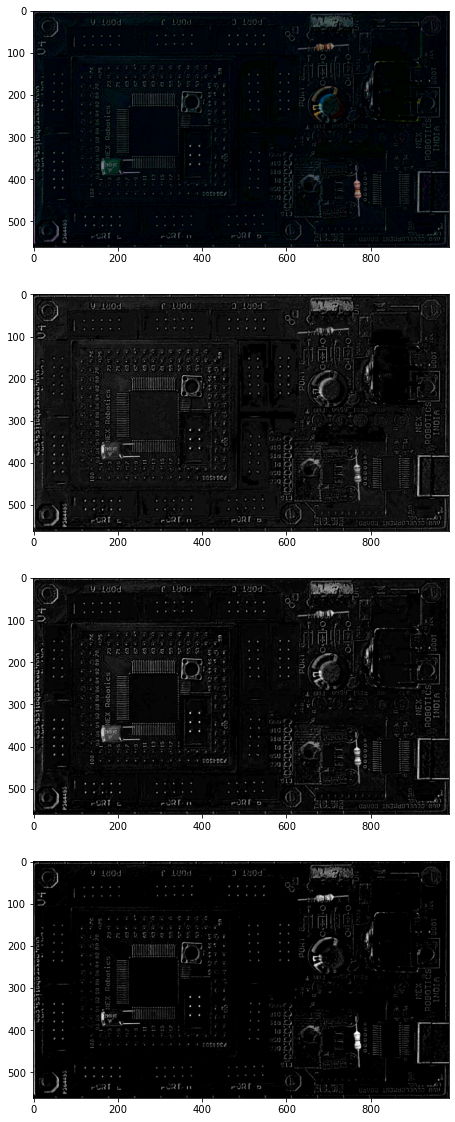

In [10]:
sub_abs,ref_otsu,train_otsu=sub_abs_thresh(refk,t_i)
f, axarr = plt.subplots(4,1,figsize=(20, 20))
axarr[0].imshow(sub_abs[:,:,::-1])
for i in range(3):
    axarr[i+1].imshow(sub_abs[:,:,i],'gray')

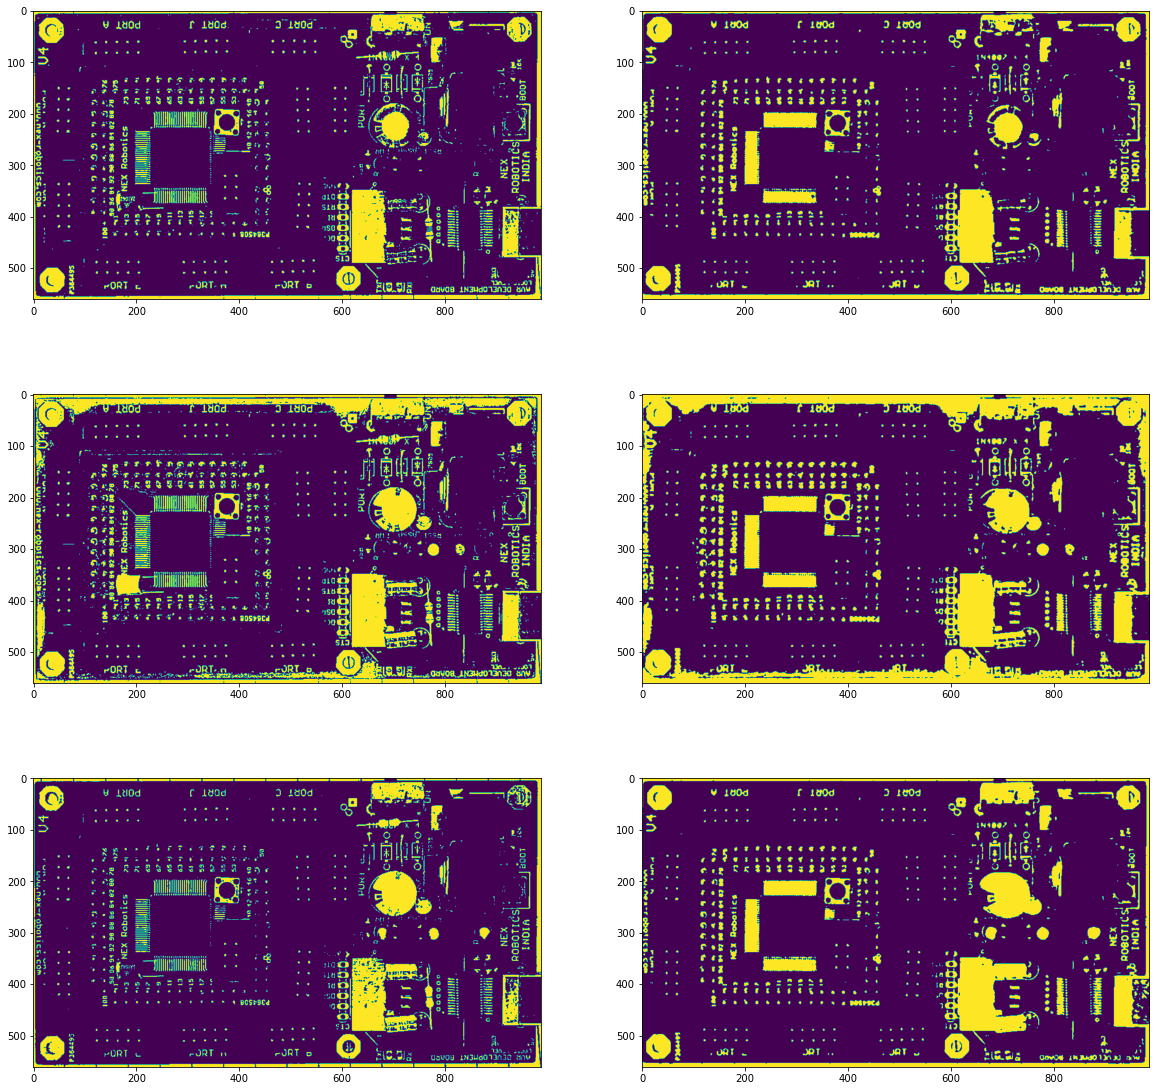

In [11]:
f, axarr = plt.subplots(3,2,figsize=(20, 20))
for i in range(3):
    axarr[i][0].imshow(ref_otsu[i])
    axarr[i][1].imshow(train_otsu[i])

In [12]:
def otsu_xor_mask(ref_l,train_l):
    b_x = np.bitwise_xor(ref_l[0],train_l[0])
    g_x = np.bitwise_xor(ref_l[1],train_l[1])
    r_x = np.bitwise_xor(ref_l[2],train_l[2])
    temp = np.bitwise_or(b_x,g_x)
    final_or =  np.bitwise_or(temp,r_x)
    return final_or

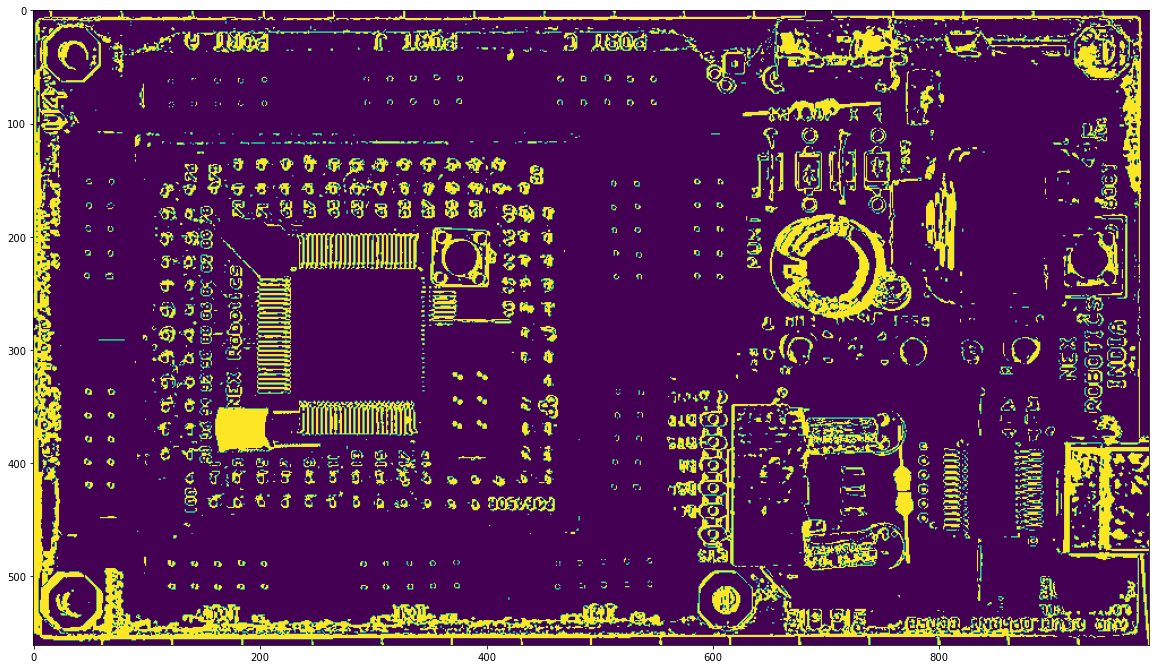

In [13]:
otsu_mask = otsu_xor_mask(ref_otsu,train_otsu)
f, axarr = plt.subplots(1,1,figsize=(20, 20))
axarr.imshow(otsu_mask)

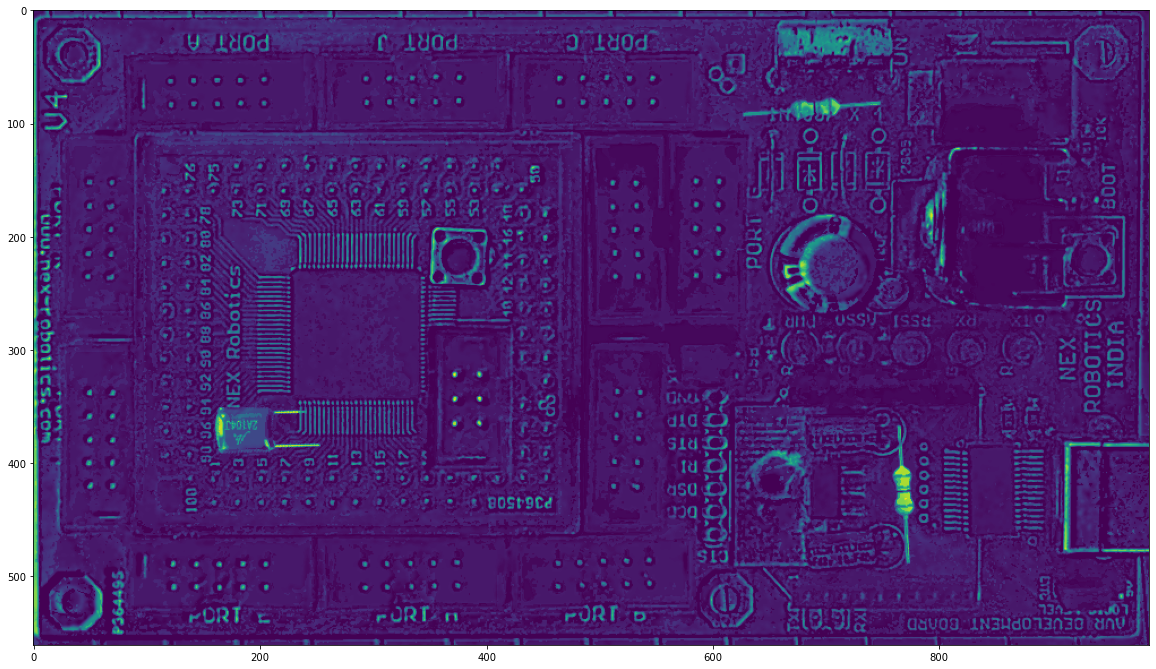

In [14]:
sub_abs_max_gray = np.max(sub_abs,axis=2)
f, axarr = plt.subplots(1,1,figsize=(20, 20))
axarr.imshow(sub_abs_max_gray)

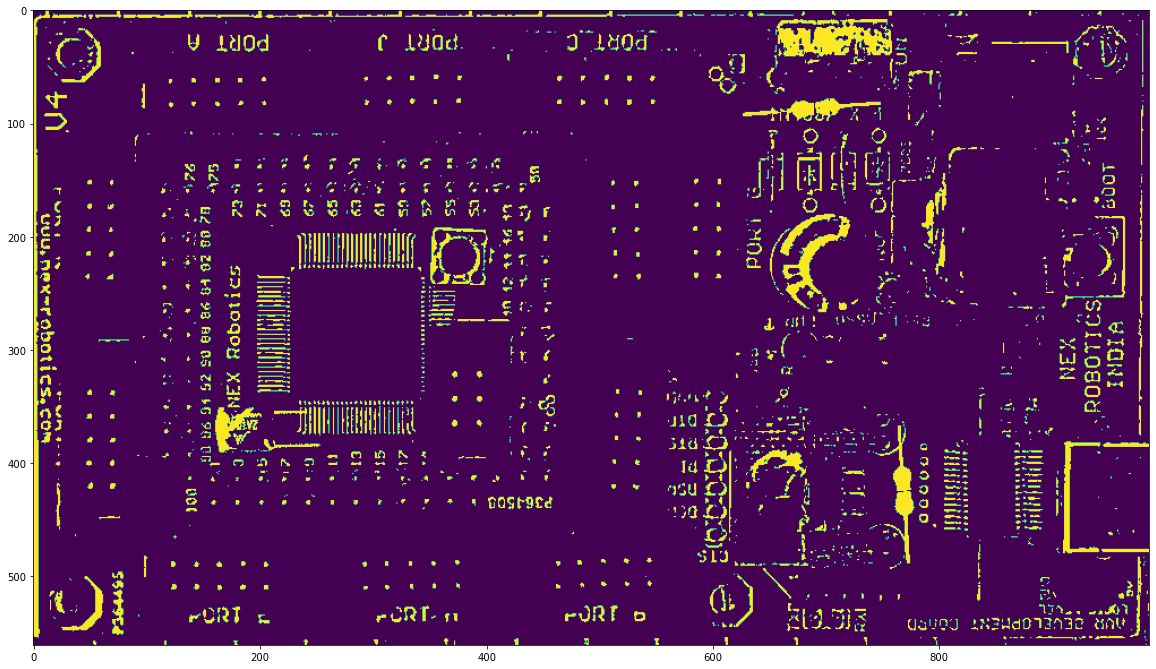

In [15]:
sub_max_thresh,otsu_sub_max = cv2.threshold(sub_abs_max_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
f, axarr = plt.subplots(1,1,figsize=(20, 20))
axarr.imshow(otsu_sub_max)

In [16]:
sub_masked_xor = np.bitwise_and(otsu_sub_max.astype(np.uint8),otsu_mask.astype(np.uint8))

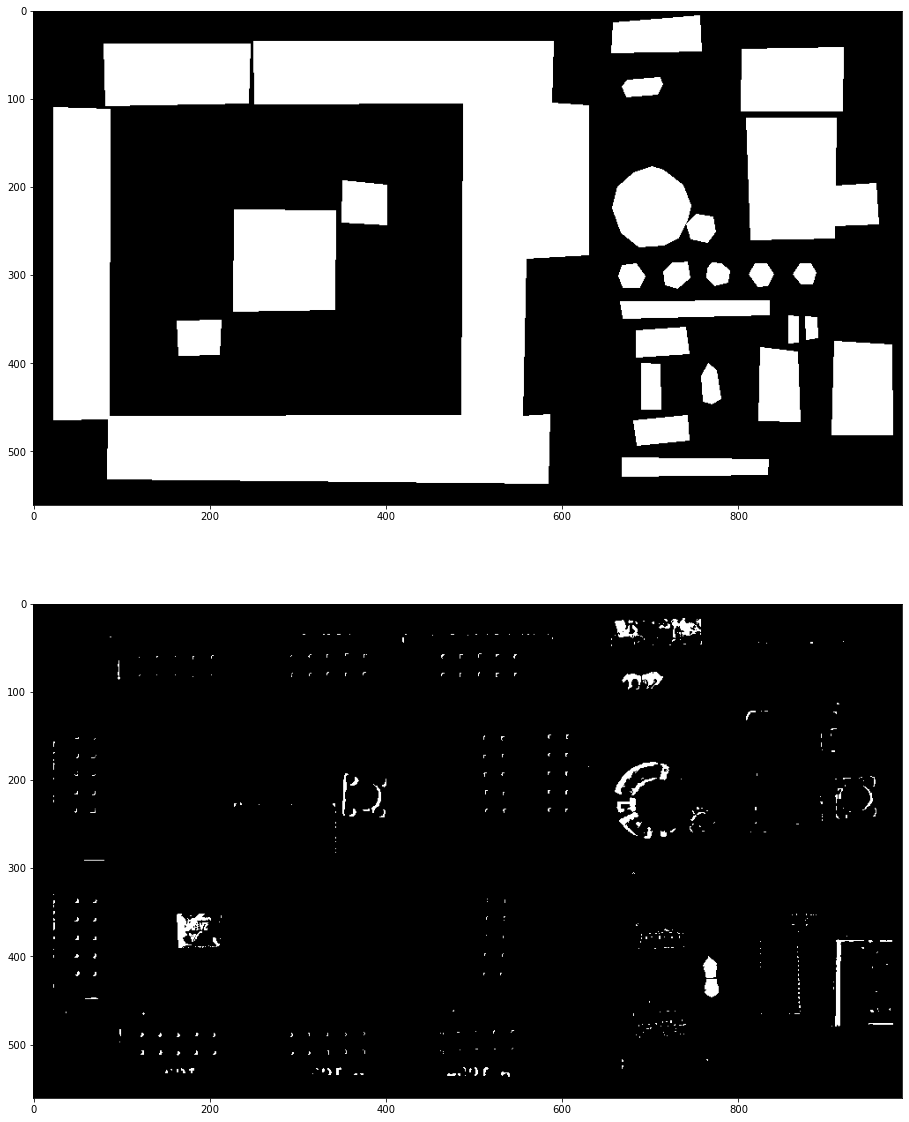

In [17]:
MASK = create_mask(ref,data,image_scale=1/n)
mask_sub = np.bitwise_and(sub_masked_xor.astype(np.uint8),MASK.astype(np.uint8))
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(MASK,'gray')
axarr[1].imshow(mask_sub,'gray')

MCU  ->  0.00263534372411716
Switch  ->  0.15958762886597938
Switch  ->  0.20145947354704197
RES  ->  0.5108695652173914
RES  ->  0.7137305699481865
CAP  ->  0.18337408312958436
CAP  ->  0.038692098092643054
CAP  ->  0.03303471444568869
POWER_JACK  ->  0.0016764459346186086
VR_BASE  ->  0.008374599475677251
Switch  ->  0.08947368421052632
IC  ->  0.016353887399463807
RES  ->  0.01881720430107527
RES  ->  0.030726256983240222
CAP  ->  0.09212121212121212
LED  ->  0.004518072289156626
LED  ->  0.0
LED  ->  0.0
LED  ->  0.0
LED  ->  0.0
IC  ->  0.001693480101608806
BUSB  ->  0.09185102212265472
CON  ->  0.0048827273519923275
CON  ->  0.009654890749438432
CON  ->  0.0
CON  ->  0.004204204204204204
CAP  ->  0.3877551020408163


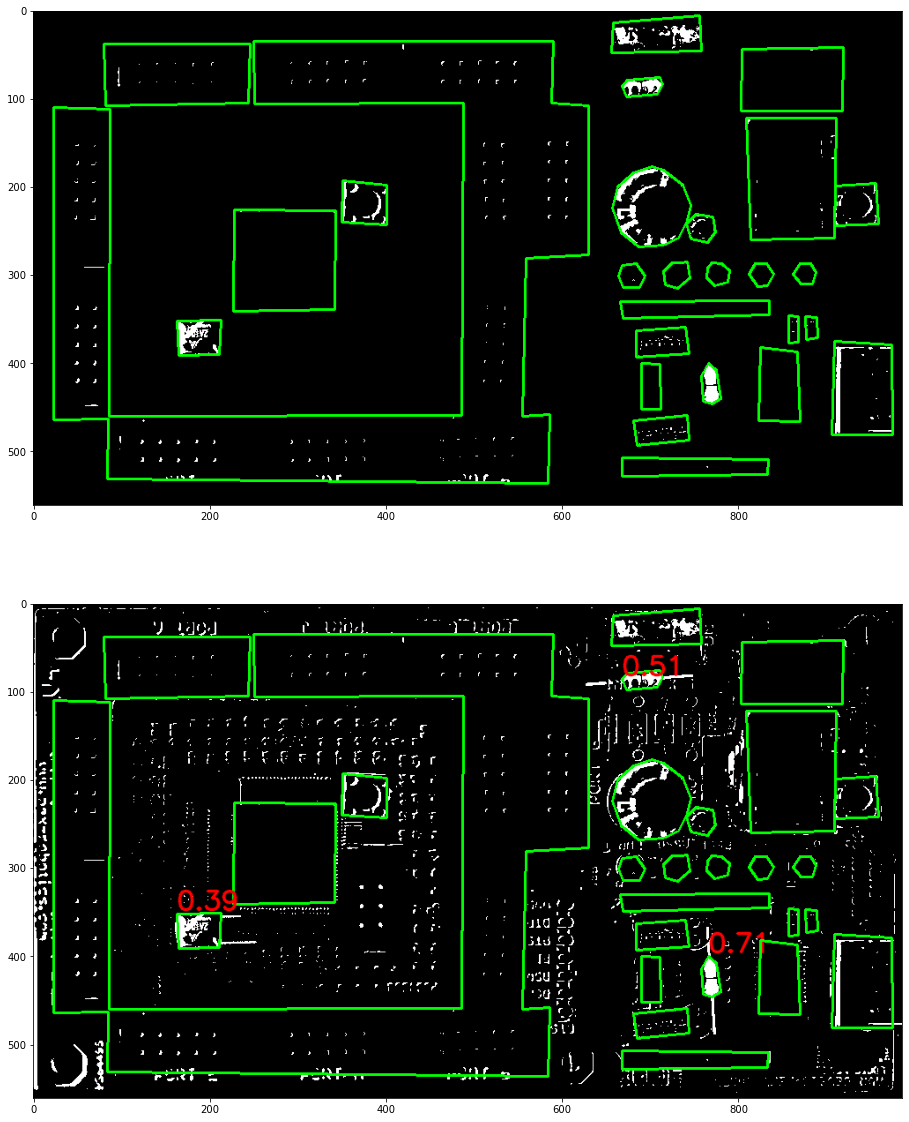

In [18]:
mask_poly = create_polyline_prob(mask_sub,data,image_scale=1/n)
P = get_fail(sub_masked_xor,data,xor_bool=False,image_scale=1/n)
mask_poly_prob = create_polyline_prob(sub_masked_xor,data,P,probs_disp = True,prob_cmp=0.3,image_scale=1/n)
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(mask_poly)
axarr[1].imshow(mask_poly_prob[:,:,::-1])